## Introduction

In this notebook, we define the problem and prepare the data for creating the model. By looking at column tip_amount we understand that it stores information about the amount of the tip given for each ride. We are interested in to find out what factors most influence the amount of the tip. We want to build a classifier that uses all information to predict whether a passenger give tips to driver. This is a binary classifier. With such a classifier we want to provide an alert for driver to predict no-tip rides.

### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from datetime import datetime


load the data saved from notebook 'Part 1-EDA'

In [2]:
df = pd.read_csv('data.csv', index_col='Unnamed: 0')

C:\Users\Nastaran\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount
0,3418135604CD3F357DD9577AF978C5C0,B25386A1F259C87449430593E904FDBC,VTS,1,2013-08-30 07:57:00,2013-08-30 08:30:00,5,1980,14.58,-73.791359,40.645657,-73.922501,40.758766,CSH,41.5,0.0,0.5,0.0,0.00
1,6D3B2A7682C30DCF64F3F12976EF93B6,A603A9D5FAA46E8FF2A97A143328D938,CMT,1,2013-08-30 23:26:23,2013-08-30 23:46:01,2,1177,11.00,-73.862724,40.769062,-73.976845,40.764595,CSH,31.0,0.5,0.5,0.0,5.33
2,6D49E494913752B75B2685E0019FF3D5,3F0BFE90A5D71741840B25600A89E225,CMT,1,2013-08-30 09:18:10,2013-08-30 09:24:08,1,357,0.80,-73.991653,40.750324,-73.986420,40.742924,CSH,5.5,0.0,0.5,0.0,0.00
3,4C4A0AFC432A1A87E97ED8F18403FF6E,BA20A20E2CF85EF7B00162D711394C7E,CMT,1,2013-08-26 23:27:11,2013-08-26 23:42:49,4,938,7.70,-73.975372,40.756237,-73.867119,40.721886,CSH,23.0,0.5,0.5,0.0,5.33
4,1258CA1DF5E2A9E9A9F7848408A7AAEB,8C14DCF69CAA2A9A0DFAFD99E00536A1,CMT,1,2013-08-29 10:57:56,2013-08-29 11:19:06,2,1270,2.10,-73.991020,40.750912,-73.996727,40.767578,CSH,14.0,0.0,0.5,0.0,0.00


In [4]:
print('Total data size is {}'.format(df.shape))


Total data size is (12579404, 19)


In [5]:
df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
dtype: int64

In [6]:
df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
dtype: object

In [7]:
df['rate_code'] = df['rate_code'].astype(str)


Lets have a look to the target variable, tip_amount

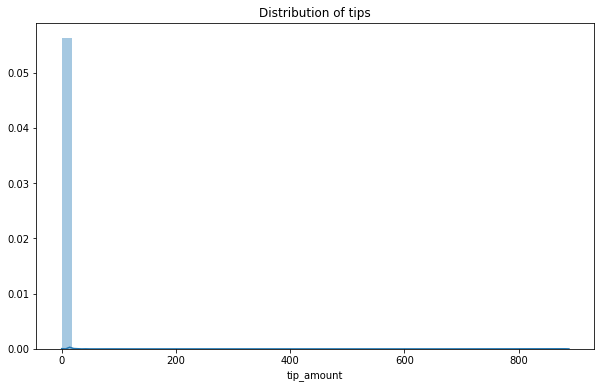

In [8]:
plt.figure(figsize = (10, 6))
sns.distplot(df['tip_amount'])
plt.title('Distribution of tips')
plt.show()

From graph above we undestand the majority of the data belongs to those does not tip. Lets explore more.

In [9]:
(len(df[df['tip_amount']!=0])/len(df))*100

51.81140537341833

In [10]:
(len(df[df['tip_amount']==0])/len(df))*100

48.18859462658167

Around 48% of passengers do not tip!Lets study the payment type and look for any correlation between tip amounts and the type of payments.

In [11]:
len(df[df['fare_amount']==0])

0

In [12]:
df['payment_type'].value_counts()

CRD    6732881
CSH    5798540
NOC      31131
DIS      10084
UNK       6768
Name: payment_type, dtype: int64

The majority of payments are done by cash or credit card

In [13]:
len(df[(df['payment_type']=='CSH')&(df['tip_amount']==0)])

5798090

In [14]:
len(df[(df['payment_type']=='CRD')&(df['tip_amount']==0)])

222714

In [15]:
len(df[(df['payment_type']=='NOC')&(df['tip_amount']==0)])

30894

In [16]:
len(df[(df['payment_type']=='DIS')&(df['tip_amount']==0)])

9995

In [17]:
len(df[(df['payment_type']=='UNK')&(df['tip_amount']==0)])

145

Total number of passengers who pay by cash are 5263584 and total number of passengers who pay by cash and do not tip are 5263135.In total only 449 passengers who pay by cash also tip.

It is the same story for NOC and DIS payment types. The total number of passenger use NOC as their payment are 31096 and there are only 237 records of passengers who tip. For DIS type of payment, there are in total 10076 records and only 89 records of passengers who tip.  

At this point, we are not sure if these huge amount of no-tip records for CSH, DIS and NOC are related to the non registered data or actually the passengers did not tip!

The maximum data for the tip does not look realistic. For getting a realistic amount we look at the maximum amount for the fare and consider 20% of that as a maxmimum for the tip amount. So, we consider any records bigger than this amount as an outlier. 

In [18]:
df['tip_amount'].describe()

count    1.257940e+07
mean     1.354893e+00
std      2.290598e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.881900e+02
Name: tip_amount, dtype: float64

In [19]:
df['fare_amount'].describe()

count    1.257940e+07
mean     1.249255e+01
std      9.931529e+00
min      2.500000e+00
25%      6.500000e+00
50%      9.500000e+00
75%      1.400000e+01
max      1.000000e+02
Name: fare_amount, dtype: float64

We consider the maximum tip as 20USD.


In [20]:
df = df[df['tip_amount']<21]

With the outliers removed, the distribution looks much better.

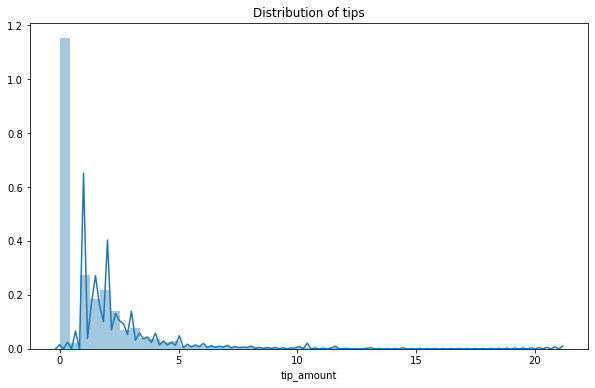

In [21]:
plt.figure(figsize = (10, 6))
sns.distplot(df['tip_amount'])
plt.title('Distribution of tips')
plt.show()

Lets check again for the percentage of tip/no-tip records.

In [22]:
print('The percentage of passengers who do not tip are {:.2f}%'.format((len(df[df['tip_amount']!=0])/len(df))*100))

The percentage of passengers who do not tip are 51.79%


In [23]:
print('The percentage of passengers who tip are {:.2f}%'.format((len(df[df['tip_amount']==0])/len(df))*100))

The percentage of passengers who tip are 48.21%


### Including date-time features


Convert the pickup and dropoff to the datetime

In [24]:
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']  = pd.to_datetime(df['dropoff_datetime'])


In [25]:
# Datetime features (hour of day, day of week)
pickup = df['pickup_datetime']
dropoff = df['dropoff_datetime']
df['pickup_hour'] = pickup.apply(lambda i: i.hour)
df['pickup_day'] = pickup.apply(lambda i: i.dayofweek)
df['dropoff_hour'] = dropoff.apply(lambda i: i.hour)
df['dropoff_day'] = dropoff.apply(lambda i: i.dayofweek)


### Correlation

We randomly get 200000 records and study the correlation

In [26]:
ds=df.sample(200000)

In [27]:
correlation = ds.corr()


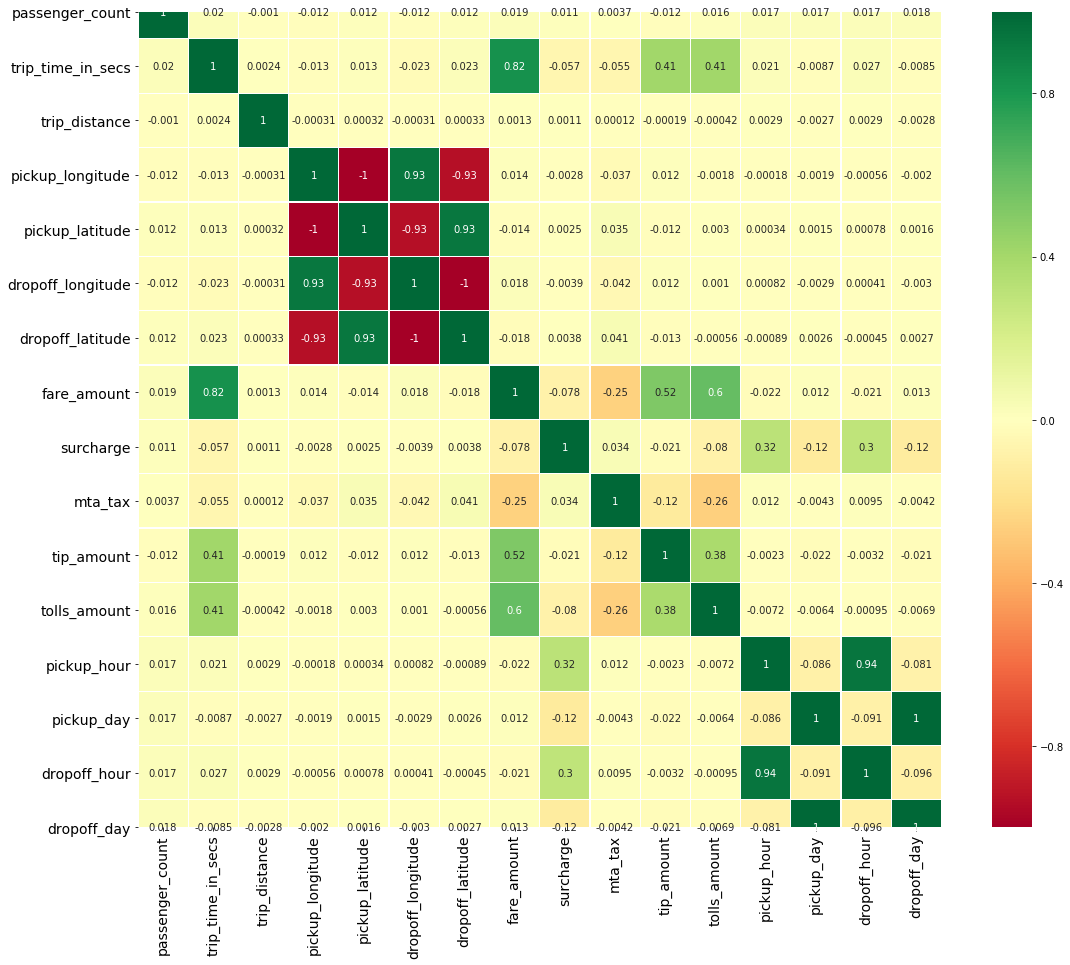

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Building Models

At first we build a model based on only two features

In [29]:
ds.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day,dropoff_hour,dropoff_day
10797115,B7D6B0EFACD1B8860AA51BD9C1B68329,1105D7686430C70CF86C1DD4D3F4507B,CMT,1,2013-08-31 02:57:28,2013-08-31 03:05:41,2,492,2.80,-74.000023,...,CRD,10.0,0.5,0.5,2.20,0.0,2,5,3,5
1849960,13E378597424D0A82D2DE84D2070D0C7,B9623D9288288F275FBFE4D03ADDD676,VTS,1,2013-08-15 22:31:00,2013-08-15 22:47:00,1,960,2.53,-73.994919,...,CRD,13.5,0.5,0.5,2.80,0.0,22,3,22,3
8224185,AA1008984C56DA85FFBA7E87F93DBDA8,45F6E77B83FE4AA576018DEC124758EB,CMT,1,2013-08-15 21:53:54,2013-08-15 22:08:00,1,845,3.00,-74.003464,...,CRD,12.0,0.5,0.5,3.25,0.0,21,3,22,3
11119090,FB43AD4A3479A18D709F045DEFE0D42F,80145385854B90203F4D0355D49AF342,CMT,1,2013-08-28 12:00:02,2013-08-28 12:19:05,1,1143,2.40,-73.980865,...,CRD,13.5,0.0,0.5,1.00,0.0,12,2,12,2
6330652,56AED6800D26D74654B3AAEB71AF991E,086926BB8B9794FBE4CC8A048D6463F8,CMT,1,2013-08-04 18:09:14,2013-08-04 18:18:48,3,574,1.30,-73.992287,...,CSH,8.0,0.0,0.5,0.00,0.0,18,6,18,6


In [30]:
ds.loc[ds.tip_amount != 0, 'tip_amount'] = 1
ds.loc[ds.tip_amount == 0, 'tip_amount'] = 0

In [31]:
ds['tip_amount'].value_counts()

1.0    103422
0.0     96578
Name: tip_amount, dtype: int64

In [32]:
y = ds['tip_amount']
x = ds[['trip_time_in_secs','passenger_count']]

In [33]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [34]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (160000, 2)
Testing data shape:  (40000, 2)


In [35]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
lr_y_pred = lr.predict(x_test)


In [37]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


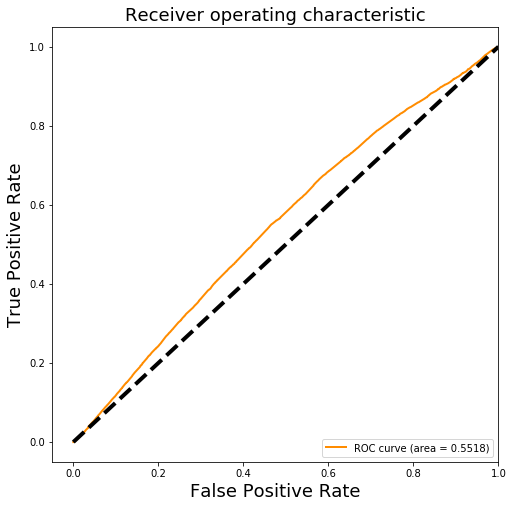

In [38]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [39]:
confusion_matrix(y_test, lr_y_pred)

array([[ 6415, 12794],
       [ 5371, 15420]], dtype=int64)

In [40]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [41]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.5459 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5465 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7417 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


### Data Preparation

In [42]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day,dropoff_hour,dropoff_day
0,3418135604CD3F357DD9577AF978C5C0,B25386A1F259C87449430593E904FDBC,VTS,1,2013-08-30 07:57:00,2013-08-30 08:30:00,5,1980,14.58,-73.791359,...,CSH,41.5,0.0,0.5,0.0,0.00,7,4,8,4
1,6D3B2A7682C30DCF64F3F12976EF93B6,A603A9D5FAA46E8FF2A97A143328D938,CMT,1,2013-08-30 23:26:23,2013-08-30 23:46:01,2,1177,11.00,-73.862724,...,CSH,31.0,0.5,0.5,0.0,5.33,23,4,23,4
2,6D49E494913752B75B2685E0019FF3D5,3F0BFE90A5D71741840B25600A89E225,CMT,1,2013-08-30 09:18:10,2013-08-30 09:24:08,1,357,0.80,-73.991653,...,CSH,5.5,0.0,0.5,0.0,0.00,9,4,9,4
3,4C4A0AFC432A1A87E97ED8F18403FF6E,BA20A20E2CF85EF7B00162D711394C7E,CMT,1,2013-08-26 23:27:11,2013-08-26 23:42:49,4,938,7.70,-73.975372,...,CSH,23.0,0.5,0.5,0.0,5.33,23,0,23,0
4,1258CA1DF5E2A9E9A9F7848408A7AAEB,8C14DCF69CAA2A9A0DFAFD99E00536A1,CMT,1,2013-08-29 10:57:56,2013-08-29 11:19:06,2,1270,2.10,-73.991020,...,CSH,14.0,0.0,0.5,0.0,0.00,10,3,11,3


Replace non zero tip values with 1 and the rest with 0.

In [43]:
df.loc[df.tip_amount != 0, 'tip_amount'] = 1
df.loc[df.tip_amount == 0, 'tip_amount'] = 0

In [44]:
df['tip_amount'].value_counts()

1.0    6513165
0.0    6061838
Name: tip_amount, dtype: int64

Define target and the features

In [45]:
y = df['tip_amount']
x = df.drop(['tip_amount'], axis =1 )

In [46]:
x = x.set_index(['medallion', 'hack_license'])


In [47]:
x.head()

,,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,pickup_hour,pickup_day,dropoff_hour,dropoff_day
medallion,hack_license,,,,,,,,,,,,,,,,,,,,
3418135604CD3F357DD9577AF978C5C0,B25386A1F259C87449430593E904FDBC,VTS,1,2013-08-30 07:57:00,2013-08-30 08:30:00,5,1980,14.58,-73.791359,40.645657,-73.922501,40.758766,CSH,41.5,0.0,0.5,0.00,7,4,8,4
6D3B2A7682C30DCF64F3F12976EF93B6,A603A9D5FAA46E8FF2A97A143328D938,CMT,1,2013-08-30 23:26:23,2013-08-30 23:46:01,2,1177,11.00,-73.862724,40.769062,-73.976845,40.764595,CSH,31.0,0.5,0.5,5.33,23,4,23,4
6D49E494913752B75B2685E0019FF3D5,3F0BFE90A5D71741840B25600A89E225,CMT,1,2013-08-30 09:18:10,2013-08-30 09:24:08,1,357,0.80,-73.991653,40.750324,-73.986420,40.742924,CSH,5.5,0.0,0.5,0.00,9,4,9,4
4C4A0AFC432A1A87E97ED8F18403FF6E,BA20A20E2CF85EF7B00162D711394C7E,CMT,1,2013-08-26 23:27:11,2013-08-26 23:42:49,4,938,7.70,-73.975372,40.756237,-73.867119,40.721886,CSH,23.0,0.5,0.5,5.33,23,0,23,0
1258CA1DF5E2A9E9A9F7848408A7AAEB,8C14DCF69CAA2A9A0DFAFD99E00536A1,CMT,1,2013-08-29 10:57:56,2013-08-29 11:19:06,2,1270,2.10,-73.991020,40.750912,-73.996727,40.767578,CSH,14.0,0.0,0.5,0.00,10,3,11,3


We drop the pickup_datetime and dropoff_datetime since the new date time features was added. Also, we drop the highly correlated features.

In [48]:
x = x.drop(['pickup_datetime','dropoff_datetime', 'pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_hour','dropoff_day','fare_amount'], axis =1 )

In [49]:
x.shape

(12575003, 12)

In [50]:
# one-hot encoding of categorical variables

x = pd.get_dummies(x)

In [51]:
correlation=x.corr()

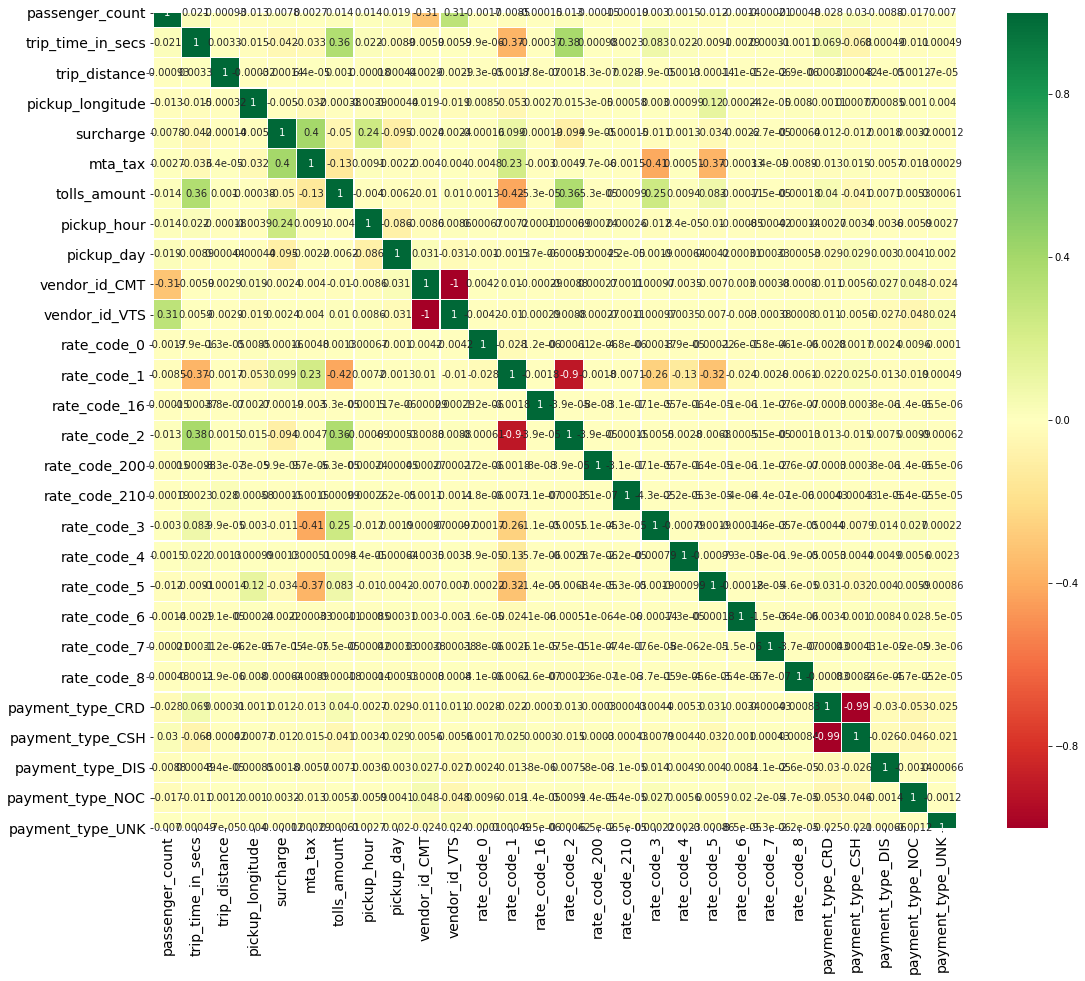

In [52]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [53]:
x=x.drop(['vendor_id_CMT','rate_code_2','payment_type_CSH'],axis=1)

In [54]:
#Features name

features_name = list(x.columns)
features_name

['passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'surcharge',
 'mta_tax',
 'tolls_amount',
 'pickup_hour',
 'pickup_day',
 'vendor_id_VTS',
 'rate_code_0',
 'rate_code_1',
 'rate_code_16',
 'rate_code_200',
 'rate_code_210',
 'rate_code_3',
 'rate_code_4',
 'rate_code_5',
 'rate_code_6',
 'rate_code_7',
 'rate_code_8',
 'payment_type_CRD',
 'payment_type_DIS',
 'payment_type_NOC',
 'payment_type_UNK']

In [55]:
x.shape


(12575003, 25)

In [56]:
#Spliting the train and test data

x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.6)

In [57]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (5030001, 25)
Testing data shape:  (7545002, 25)


#### First Model: Logistic Regression

We create a simple logestic model.

In [61]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
lr_y_pred = lr.predict(x_test)


In [63]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


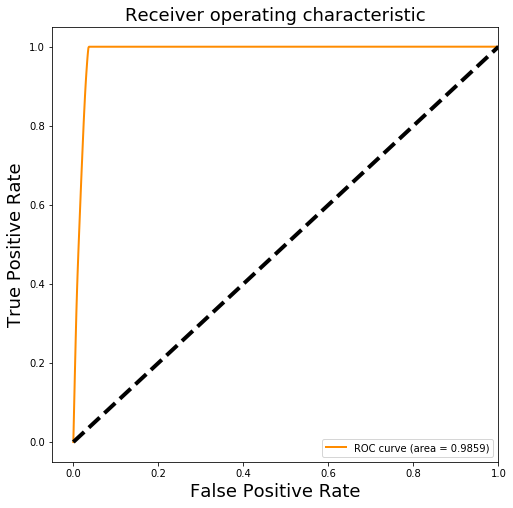

In [64]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [65]:
confusion_matrix(y_test, lr_y_pred)

array([[3504451,  133704],
       [    573, 3906274]], dtype=int64)

In [66]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [67]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.9822 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9669 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9999 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [68]:
lr.coef_

array([[-6.61639599e-02, -2.47267063e+01,  0.00000000e+00,
        -6.82949511e-01, -1.15844603e+02,  0.00000000e+00,
         2.48878650e+00,  4.64154076e-01, -4.02626966e-01,
        -5.05107678e-01, -3.16475319e+00,  2.36738902e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.70041595e-01, -6.39052658e-01, -2.28720042e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.29764479e+01,  4.56302855e+00,  4.30628607e+00,
         1.36901194e+01]])

In [69]:
coef_table = pd.DataFrame(list(features_name)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())

In [70]:
coef_table

,0,Coefs
0,passenger_count,-0.066164
1,trip_time_in_secs,-24.726706
2,trip_distance,0.000000
3,pickup_longitude,-0.682950
4,surcharge,-115.844603
5,mta_tax,0.000000
6,tolls_amount,2.488787
7,pickup_hour,0.464154
8,pickup_day,-0.402627
9,vendor_id_VTS,-0.505108


In [ ]:
# x['surcharge'].value_counts()

Drop surcharge column

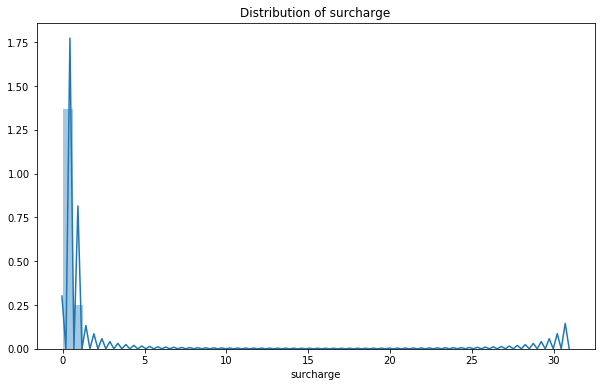

In [71]:
plt.figure(figsize = (10, 6))
sns.distplot(df[df['surcharge']<100]['surcharge'])
plt.title('Distribution of surcharge')
plt.show()



In [72]:
(len(df[df['surcharge']==0])/len(df))*100

49.230803364420666

In [73]:
x=x.drop(['surcharge'],axis=1)

In [74]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.6)

In [75]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (5030001, 24)
Testing data shape:  (7545002, 24)


In [76]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
lr_y_pred = lr.predict(x_test)


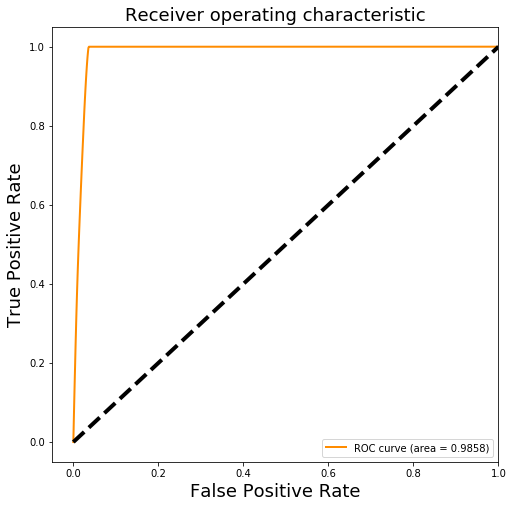

In [78]:
lr_y_prob = lr.predict_proba(x_test)[:,1]

# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()


In [79]:
confusion_matrix(y_test, lr_y_pred)

array([[3504449,  133706],
       [    568, 3906279]], dtype=int64)

In [80]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.9822 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9669 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9999 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [81]:
x.columns

Index(['passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'mta_tax', 'tolls_amount', 'pickup_hour',
       'pickup_day', 'vendor_id_VTS', 'rate_code_0', 'rate_code_1',
       'rate_code_16', 'rate_code_200', 'rate_code_210', 'rate_code_3',
       'rate_code_4', 'rate_code_5', 'rate_code_6', 'rate_code_7',
       'rate_code_8', 'payment_type_CRD', 'payment_type_DIS',
       'payment_type_NOC', 'payment_type_UNK'],
      dtype='object')

In [82]:
coef_table = pd.DataFrame(list(x.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())
coef_table

,0,Coefs
0,passenger_count,-0.069343
1,trip_time_in_secs,-24.564861
2,trip_distance,0.000000
3,pickup_longitude,-0.680921
4,mta_tax,0.000000
5,tolls_amount,2.973521
6,pickup_hour,0.407486
7,pickup_day,-0.389514
8,vendor_id_VTS,-0.504451
9,rate_code_0,-3.172754


#### Different approch

The second approach is to remove all the payment type related to CSH,DIS and NOC which have the major amounts of no-tip records and introduce slightly a different approch. We assum that the high records for zero tip might be related to non registered data. So, we build a model based on CRD and NOC payment type.

first we creat some random sample from our main dataset

In [83]:
ds=df.sample(200000)

In [84]:
ds = ds.drop(ds[(ds['payment_type']=='CSH')].index, axis=0)

In [85]:
ds = ds.drop(ds[(ds['payment_type']=='DIS')|(ds['payment_type']=='NOC')].index, axis=0)

In [86]:
y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )

In [87]:
y.value_counts()

1.0    103646
0.0      3605
Name: tip_amount, dtype: int64

is it imbalance data set???

In [88]:
x = x.set_index(['medallion', 'hack_license'])


In [89]:
x = x.drop(['pickup_datetime','dropoff_datetime', 'pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_hour','dropoff_day','fare_amount','surcharge'], axis =1 )

In [90]:
x.head()

,,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,payment_type,mta_tax,tolls_amount,pickup_hour,pickup_day
medallion,hack_license,,,,,,,,,,,
67FBB1DD88BC587325775BB298FBFA0E,F8C875BC7D90B09E054FFD1A740D2BD7,CMT,1,1,161,0.40,-73.974365,CRD,0.5,0.0,20,3
540D3191C384FBA05474473BCE91E67F,826291AF8908663A7A1522E0451B3043,VTS,1,5,1200,3.57,-73.993683,CRD,0.5,0.0,19,4
98CE25F479A9E406681CB3E28F6B3C61,98F40284FDEF7A58B6CA0C4FDB1A82E6,CMT,1,1,545,2.00,-73.986931,CRD,0.5,0.0,0,3
A65364D79584EA8A2A998DED2255D366,330799EE0EB8649DFF029286D7394C0A,VTS,1,6,600,1.76,-73.978256,CRD,0.5,0.0,9,3
24B947E1319F6ADBC55FB4B218FE4CC9,5F3AC6FD6B38F18E26F1E285EECAEA68,CMT,1,1,784,2.00,-73.953880,CRD,0.5,0.0,18,3


In [91]:
x.shape

(107251, 11)

In [92]:
x = pd.get_dummies(x)

In [93]:
x=x.drop(['payment_type_UNK','rate_code_1','vendor_id_VTS'],axis=1)

In [94]:
#Spliting the train and test data

x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [95]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (85800, 14)
Testing data shape:  (21451, 14)


In [96]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
lr_y_pred = lr.predict(x_test)


In [98]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


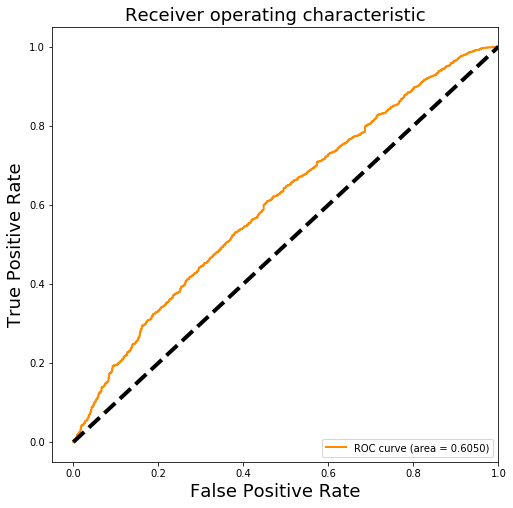

In [99]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [100]:
confusion_matrix(y_test, lr_y_pred)

array([[    0,   726],
       [    0, 20725]], dtype=int64)

In [101]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [102]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.9662 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9662 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


### Second Model: Random Forest


In [103]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1)


In [104]:
random_forest.fit(x_train,y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [105]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': x, 'importance': feature_importance_values})

In [106]:
feature_importances


,feature,importance
0,"(p, a, s, s, e, n, g, e, r, _, c, o, u, n, t)",0.039161
1,"(t, r, i, p, _, t, i, m, e, _, i, n, _, s, e, ...",0.236425
2,"(t, r, i, p, _, d, i, s, t, a, n, c, e)",0.126379
3,"(p, i, c, k, u, p, _, l, o, n, g, i, t, u, d, e)",0.370603
4,"(m, t, a, _, t, a, x)",0.003940
5,"(t, o, l, l, s, _, a, m, o, u, n, t)",0.009988
6,"(p, i, c, k, u, p, _, h, o, u, r)",0.125179
7,"(p, i, c, k, u, p, _, d, a, y)",0.069237
8,"(v, e, n, d, o, r, _, i, d, _, C, M, T)",0.006779
9,"(r, a, t, e, _, c, o, d, e, _, 2)",0.002979


In [107]:
rf_y_pred = random_forest.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [108]:
rf_y_prob = random_forest.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


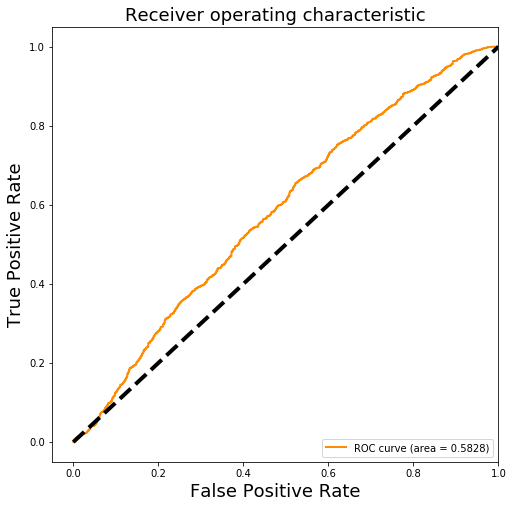

In [109]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [110]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.9664 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9667 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9996 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


#### Random Forest: different hyperparameter


In [111]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='entropy',class_weight='balanced', max_depth=10 ,random_state = 50, verbose = 1)


In [112]:
rf.fit(x_train,y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [113]:
rf_y_pred = rf.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


In [114]:
rf_y_prob = rf.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


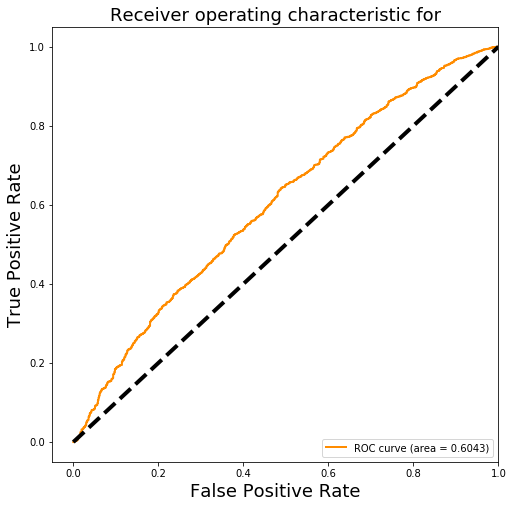

In [115]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [116]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.7523 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9717 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7659 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [117]:
feature_importance_values = rf.feature_importances_


In [118]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


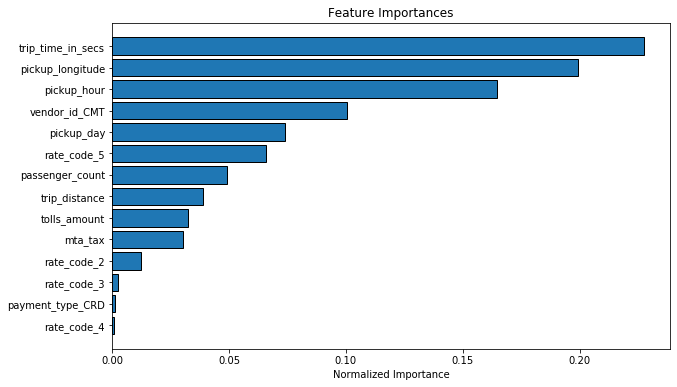

In [119]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

### Third Model: XGBoost

In [120]:
xgb = XGBClassifier(binary='logistic', random_state=50, )


In [121]:
xgb.fit(x_train,y_train)


XGBClassifier(base_score=0.5, binary='logistic', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [122]:
xgb_y_pred = xgb.predict(x_test)


In [123]:
xgb_y_prob = xgb.predict_proba(x_test)[:, 1]


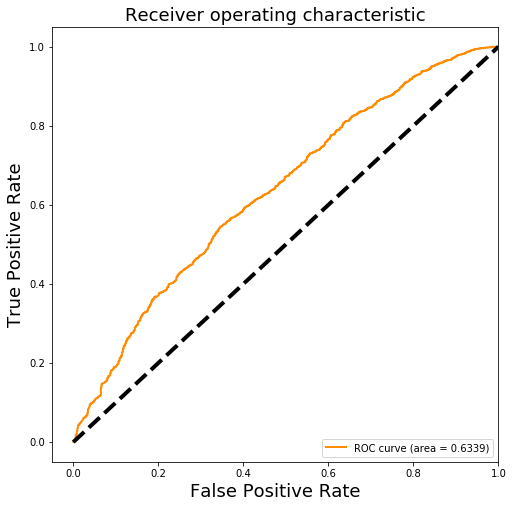

In [124]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [125]:
summary_report(y_test, xgb_y_pred)


Accuracy : 0.9663 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9663 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [126]:
#importance feature
feature_importance_values = xgb.feature_importances_

In [127]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


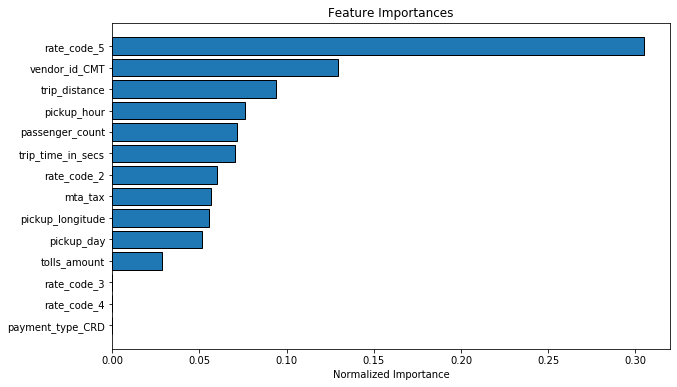

In [128]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

### Imbalanced data set- Over Sampling

In [129]:
ds.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day,dropoff_hour,dropoff_day
7117266,67FBB1DD88BC587325775BB298FBFA0E,F8C875BC7D90B09E054FFD1A740D2BD7,CMT,1,2013-08-08 20:30:10,2013-08-08 20:32:51,1,161,0.40,-73.974365,...,CRD,4.0,0.5,0.5,1.0,0.0,20,3,20,3
2008456,540D3191C384FBA05474473BCE91E67F,826291AF8908663A7A1522E0451B3043,VTS,1,2013-08-16 19:04:00,2013-08-16 19:24:00,5,1200,3.57,-73.993683,...,CRD,15.5,1.0,0.5,1.0,0.0,19,4,19,4
7840891,98CE25F479A9E406681CB3E28F6B3C61,98F40284FDEF7A58B6CA0C4FDB1A82E6,CMT,1,2013-08-15 00:49:36,2013-08-15 00:58:41,1,545,2.00,-73.986931,...,CRD,10.0,0.5,0.5,1.0,0.0,0,3,0,3
4878854,A65364D79584EA8A2A998DED2255D366,330799EE0EB8649DFF029286D7394C0A,VTS,1,2013-08-29 09:55:00,2013-08-29 10:05:00,6,600,1.76,-73.978256,...,CRD,9.0,0.0,0.5,1.0,0.0,9,3,10,3
8459743,24B947E1319F6ADBC55FB4B218FE4CC9,5F3AC6FD6B38F18E26F1E285EECAEA68,CMT,1,2013-08-15 18:13:15,2013-08-15 18:26:19,1,784,2.00,-73.953880,...,CRD,12.0,1.0,0.5,1.0,0.0,18,3,18,3


In [130]:
y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )

In [131]:
y.value_counts()

1.0    103646
0.0      3605
Name: tip_amount, dtype: int64

In [132]:
x.shape

(107251, 22)

In [133]:
x = x.drop(['medallion', 'hack_license'],axis=1)


In [134]:
correlation = x.corr()


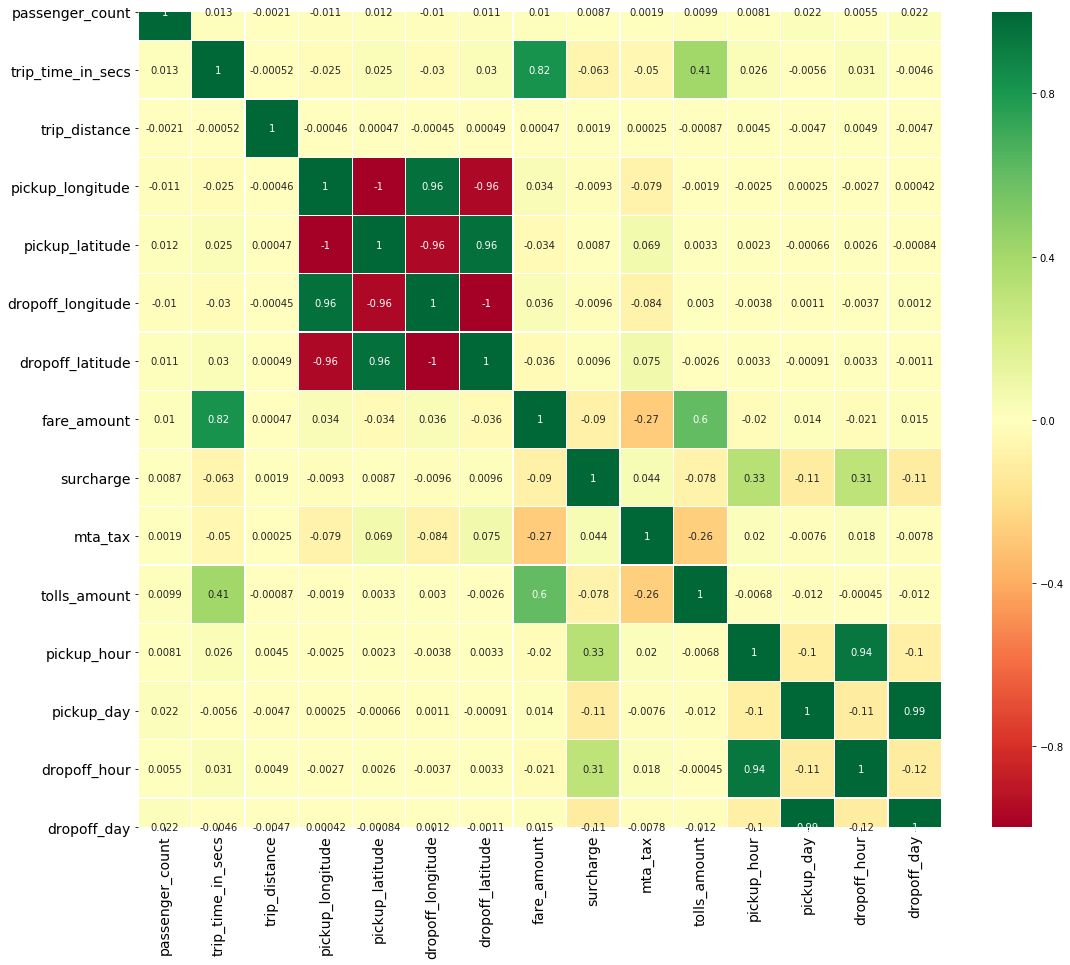

In [135]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [136]:
x = x.drop(['pickup_datetime','dropoff_datetime', 'pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_hour','dropoff_day','fare_amount'], axis =1 )

In [137]:
x.dtypes

vendor_id             object
rate_code             object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
payment_type          object
surcharge            float64
mta_tax              float64
tolls_amount         float64
pickup_hour            int64
pickup_day             int64
dtype: object

In [138]:
x = pd.get_dummies(x)

In [139]:
correlation = x.corr()


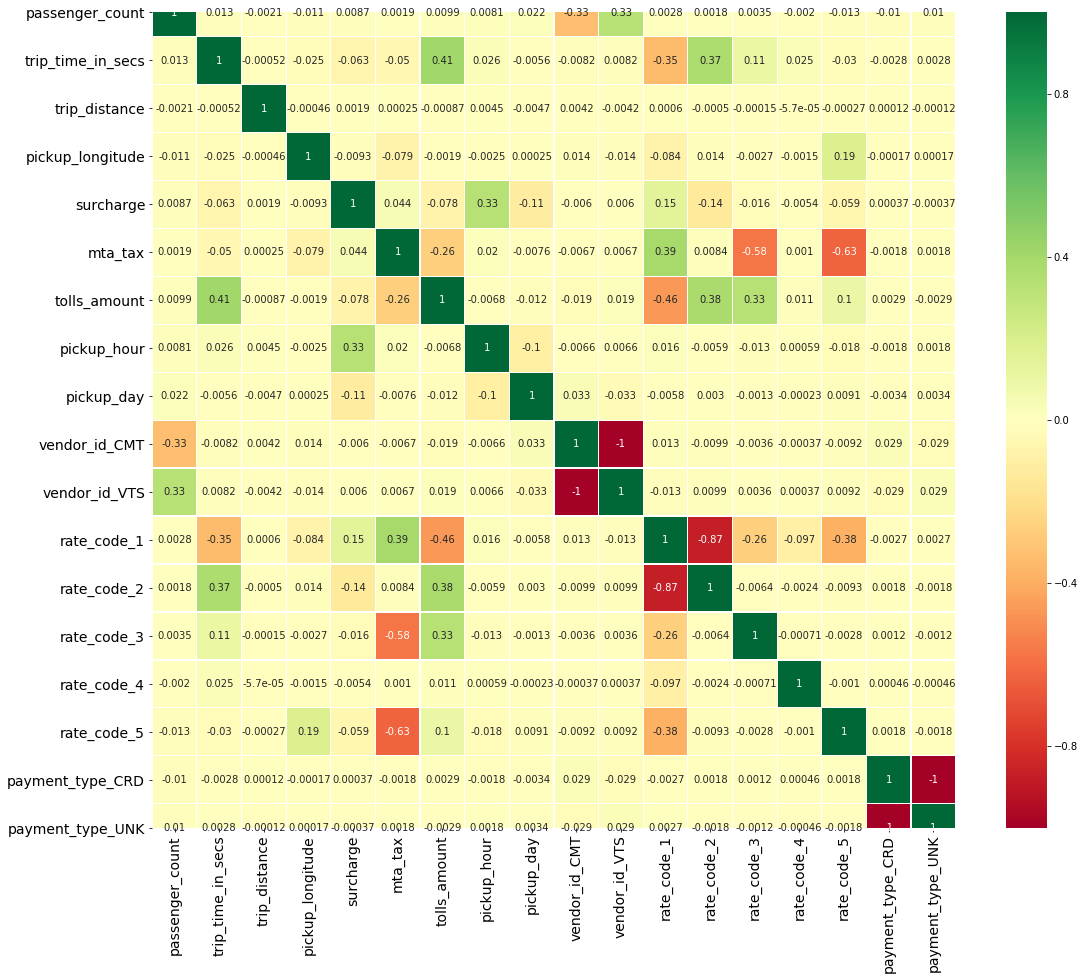

In [140]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [141]:
x = x.drop(['payment_type_UNK','rate_code_1','vendor_id_VTS'], axis =1 )

In [142]:
x=x.drop(['surcharge'],axis=1)

In [143]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 42, test_size=0.2)


In [144]:
features = x_train.columns
features

Index(['passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'mta_tax', 'tolls_amount', 'pickup_hour',
       'pickup_day', 'vendor_id_CMT', 'rate_code_2', 'rate_code_3',
       'rate_code_4', 'rate_code_5', 'payment_type_CRD'],
      dtype='object')

In [145]:
df_train = pd.concat((x_train, y_train), axis=1)


In [146]:
df_train.head()

,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,mta_tax,tolls_amount,pickup_hour,pickup_day,vendor_id_CMT,rate_code_2,rate_code_3,rate_code_4,rate_code_5,payment_type_CRD,tip_amount
2914642,1,1800,18.72,-73.782074,0.5,0.0,22,1,0,1,0,0,0,1,1.0
9755731,1,514,1.30,-73.989738,0.5,0.0,11,5,1,0,0,0,0,1,0.0
2862748,2,480,1.12,-73.998459,0.5,0.0,18,1,0,0,0,0,0,1,1.0
2251048,2,960,3.35,-73.970734,0.5,0.0,18,5,0,0,0,0,0,1,1.0
1434233,5,180,0.87,-73.974297,0.5,0.0,1,2,0,0,0,0,0,1,1.0


### Over-sampling


In [147]:
df_train['tip_amount'].value_counts()

1.0    82922
0.0     2878
Name: tip_amount, dtype: int64

In [148]:
#class count
count_class_1, count_class_0 = df_train['tip_amount'].value_counts()

In [149]:
print(count_class_0)
print(count_class_1)

2878
82922


In [150]:
#Divide by class
df_class_0 = df_train[df_train['tip_amount'] == 0]
df_class_1 = df_train[df_train['tip_amount'] == 1]

In [151]:
df_class_1_under = df_class_1.sample(count_class_0)


In [152]:
df_under = pd.concat([df_class_1_under, df_class_0], axis=0)


In [153]:
print('Random under_sampling:')
print(df_under['tip_amount'].value_counts())

Random under_sampling:
0.0    2878
1.0    2878
Name: tip_amount, dtype: int64


### Modeling

In [154]:
y = df_under['tip_amount']
x = df_under.drop(['tip_amount'], axis =1 )

In [155]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

print('Training data shape: ', x.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (5756, 14)
Testing data shape:  (21451, 14)


#### 4.1 Logestic Regression


In [156]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
lr_y_pred = lr.predict(x_test)
lr_y_prob = lr.predict_proba(x_test)[:,1]

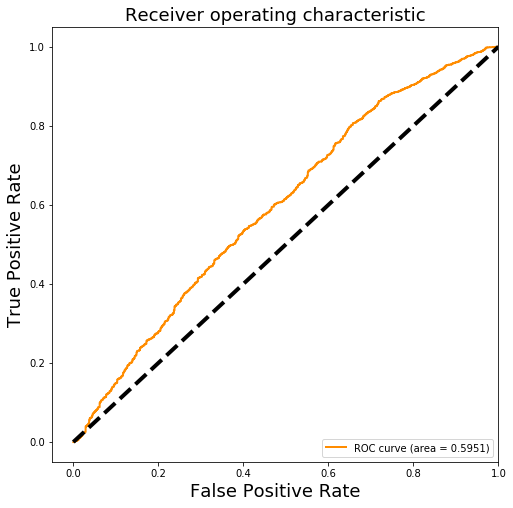

In [158]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [159]:
confusion_matrix(y_test, lr_y_pred)


array([[  349,   378],
       [ 7552, 13172]], dtype=int64)

In [160]:
summary_report(y_test, lr_y_pred)


Accuracy : 0.6303 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9721 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6356 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


#### 4.2 Random Forest

In [161]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', max_depth=10 ,random_state = 50, verbose = 1)


In [162]:
rf.fit(x,y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [163]:
rf_y_pred = rf.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


In [164]:
rf_y_prob = rf.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


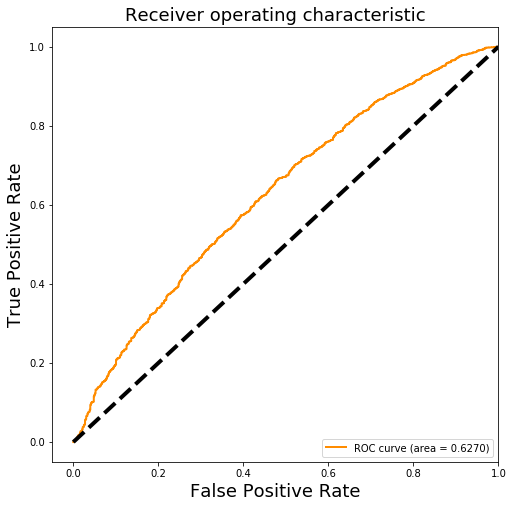

In [165]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [166]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.6888 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9746 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6961 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [167]:
#importance feature
feature_importance_values = rf.feature_importances_

In [168]:
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values})

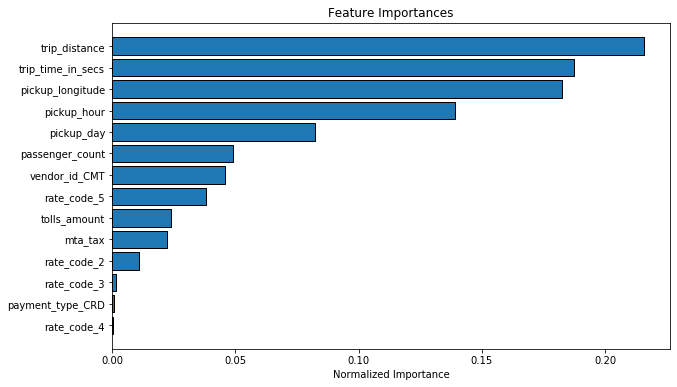

In [169]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

#### 4.3 XGBoost


In [170]:
xgb = XGBClassifier(binary='logistic', random_state=50, max_depth=10, reg_alpha=10 )


In [171]:
xgb.fit(x,y)


XGBClassifier(base_score=0.5, binary='logistic', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [172]:
xgb_y_pred = xgb.predict(x_test)


In [173]:
xgb_y_prob = xgb.predict_proba(x_test)[:, 1]


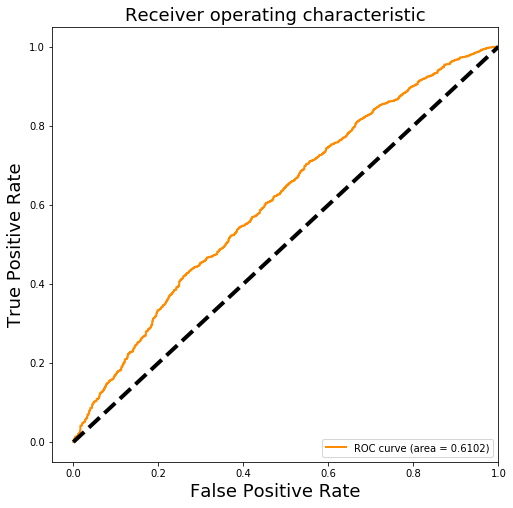

In [174]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [175]:
summary_report(y_test, xgb_y_pred)


Accuracy : 0.6011 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9743 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6030 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [176]:
feature_importance_values_xgb = xgb.feature_importances_


In [177]:
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values_xgb})

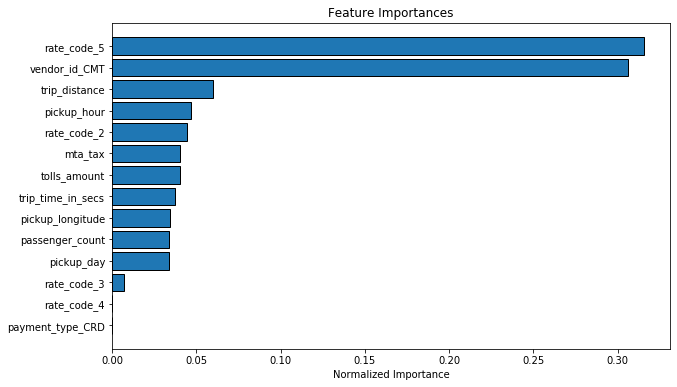

In [178]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()